## Training a Coupon Subscription Model
### Objective
The objective of this notebook is to train a binary classification model that can predict subscription of coupon and hence, automate loan approvals.

### 1. Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="ticks", palette="pastel")

def remove_outliers(df, col: str):
    q3 = np.quantile(df[col], 0.75)
    q1 = np.quantile(df[col], 0.25)
    l_lmt = q1 - 1.5 * (q3 - q1)
    u_lmt = q3 + 1.5 * (q3 - q1)
    return df[(df[col] >= l_lmt) & (df[col] <= u_lmt)].copy()
    
#Read Sample Dataset
raw_df = pd.read_csv('/Users/arielhe/Desktop/EBAC/SolutionImplementation/D2/dssi-py-main-copy/data/coupon_sub.csv')
raw_df.head()

,subscribed,yearly_income,is_female,is_married,colg_edu,is_professional,is_retired,is_unemployed,months_residence,dual_income,have_minors,own_house,race_white,speak_english
0,0,24000,1,0,1,1,0,0,26,0,0,0,0,0
1,1,75000,1,1,1,1,0,0,15,1,0,1,1,1
2,0,46000,1,1,0,0,0,0,36,1,1,1,1,1
3,1,70000,0,1,0,1,0,0,55,0,0,1,1,1
4,0,43000,1,0,0,0,0,0,27,0,0,0,1,1


In [3]:
#Check number of records and columns
print(raw_df.shape)

(673, 14)


In [4]:
#Check of missing values
raw_df.isnull().sum()

subscribed          0
yearly_income       0
is_female           0
is_married          0
colg_edu            0
is_professional     0
is_retired          0
is_unemployed       0
months_residence    0
dual_income         0
have_minors         0
own_house           0
race_white          0
speak_english       0
dtype: int64

In [5]:
raw_df.describe(include='all')

,subscribed,yearly_income,is_female,is_married,colg_edu,is_professional,is_retired,is_unemployed,months_residence,dual_income,have_minors,own_house,race_white,speak_english
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000
mean,0.185736,35078.751857,0.551263,0.349183,0.289747,0.341753,0.057949,0.031204,17.618128,0.231798,0.364042,0.362556,0.692422,0.909361
std,0.389182,23812.787498,0.497735,0.477066,0.453982,0.474650,0.233822,0.173997,13.555818,0.422294,0.481518,0.481096,0.461834,0.287308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,32000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,52000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,24.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,75000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
def log_txf(df, cols: list):
    for col in cols:
        df['log_'+col] = np.log(df[col]+1)
    return df
    
raw_df.describe(include='all')

,subscribed,yearly_income,is_female,is_married,colg_edu,is_professional,is_retired,is_unemployed,months_residence,dual_income,have_minors,own_house,race_white,speak_english
count,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000,673.000000
mean,0.185736,35078.751857,0.551263,0.349183,0.289747,0.341753,0.057949,0.031204,17.618128,0.231798,0.364042,0.362556,0.692422,0.909361
std,0.389182,23812.787498,0.497735,0.477066,0.453982,0.474650,0.233822,0.173997,13.555818,0.422294,0.481518,0.481096,0.461834,0.287308
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,32000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,52000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,24.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,75000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000


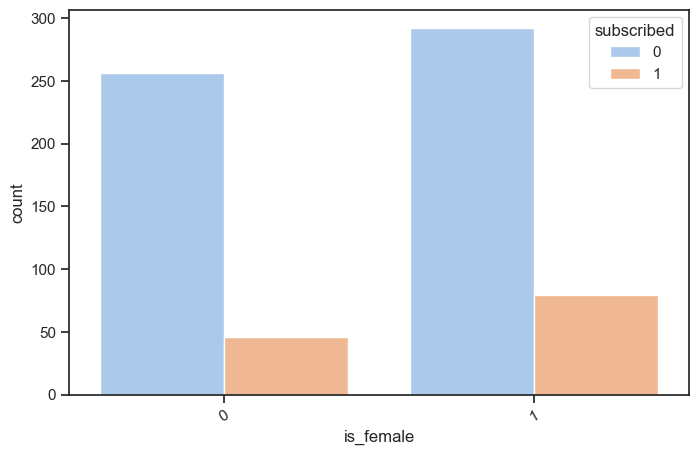

In [7]:
plt.figure(figsize=(8,5))
g = sns.countplot(raw_df, x="is_female", hue="subscribed")
g = g.set_xticklabels(g.get_xticklabels(), rotation=30)

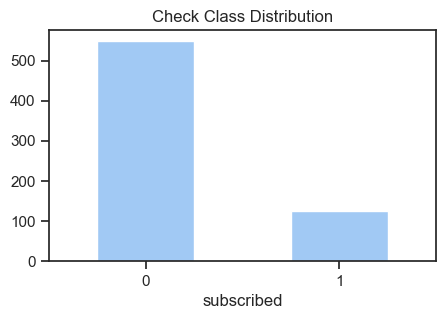

In [10]:
plt.figure(figsize=(5,3))
g = raw_df['subscribed'].value_counts().plot.bar(title='Check Class Distribution', rot=0)

### 3. Data Preprocessing

In [11]:
#Select features that are discriminatory and uncorrelated
features = ['yearly_income','is_female','is_married','colg_edu','is_professional','is_retired','is_unemployed','months_residence','dual_income','have_minors','own_house','race_white','speak_english']
numeric_features = ['months_residence','yearly_income']
categorical_features = ['is_female','is_married','colg_edu','is_professional','is_retired','is_unemployed','dual_income','have_minors','own_house','race_white','speak_english']
label = 'subscribed'

numeric_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

dat = preprocessor.fit_transform(raw_df)
new_cols = numeric_features + \
list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

trf_df = pd.DataFrame(dat, columns=new_cols)
trf_df.head()

,months_residence,yearly_income,is_female_0,is_female_1,is_married_0,is_married_1,colg_edu_0,colg_edu_1,is_professional_0,is_professional_1,...,dual_income_0,dual_income_1,have_minors_0,have_minors_1,own_house_0,own_house_1,race_white_0,race_white_1,speak_english_0,speak_english_1
0,0.361111,0.320000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.208333,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.500000,0.613333,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.763889,0.933333,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.375000,0.573333,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


### 4. Modeling
#### 4.1 Train-Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(raw_df[features], \
                                                    raw_df[label], \
                                                    test_size=0.2, \
                                                    random_state=0)
X_train.head()

,yearly_income,is_female,is_married,colg_edu,is_professional,is_retired,is_unemployed,months_residence,dual_income,have_minors,own_house,race_white,speak_english
101,70000,0,1,0,1,0,0,8,0,1,0,1,1
443,75000,1,0,0,0,0,0,22,0,0,0,1,0
432,75000,1,1,0,0,0,0,23,1,0,0,1,1
298,75000,0,1,1,1,0,0,26,1,0,1,1,1
142,75000,0,1,0,0,1,0,14,0,0,1,1,1


#### 4.2 Train Classifier

In [13]:
random_forest = RandomForestClassifier(n_estimators=100,
                                       max_depth=4, 
                                       class_weight = "balanced",
                                       n_jobs=2)

clf = Pipeline(steps=[("preprocessor", preprocessor),\
                      ("binary_classifier", random_forest)]
              )

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['months_residence',
                                                   'yearly_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['is_female', 'is_married',
                                                   'colg_edu',
                                                   'is_professional',
                                                   'is_retired',
                                                   'is_unemployed',
                                                   'dual_income', 'have_minors',
                                                   'own_house', 'race_white',
                                                   'speak_english'])])),
                ('binary_classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        n_jobs=2))])

### 5. Evaluation

In [14]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       114
           1       0.63      0.90      0.75        21

    accuracy                           0.90       135
   macro avg       0.81      0.90      0.84       135
weighted avg       0.93      0.90      0.91       135

